In [1]:
"""
Main script to train and run an object detection model

Utilizes scipts from data_utils that include many of the major training componenets

Import both pretrained Faster RCNN and FFA_net and utilize in a pipeline
"""

'\nMain script to train and run an object detection model\n\nUtilizes scipts from data_utils that include many of the major training componenets\n\nImport both pretrained Faster RCNN and FFA_net and utilize in a pipeline\n'

In [2]:
import torch
from torchvision import transforms, datasets
import torchvision

# Import common neural network API in pytorch
import torch.nn as nn
import torch.nn.functional as F


# Import optimizer related API
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Check device, using gpu 0 if gpu exist else using cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import numpy as np
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


from matplotlib import image
from PIL import Image
from torchvision import transforms as tfs
import os
import matplotlib.patches as patches

import matplotlib.pyplot as plt
from data_utils import *
from ffa_net import *

cuda
cuda


In [8]:
#get the data and load the model
from ffa_net import *
data_ = CustomDatasetTrain("./CVPR_comp/train/haze_images/", './CVPR_comp/train/haze_images_labels/')
dry_data = CustomDatasetDryRun('./CVPR_comp/new_dry_run/images/', './CVPR_comp/new_dry_run/labels/')


#sets whether to use the pretrained resnet 50 or a custom model that we build
online_model = True
if online_model:
    print('Loaded online model')
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers= 5)
    num_classes = 2
    features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(features, num_classes)
else:
    print('Loaded custom model')
    model = torch.load("./CVPR_comp/models/fasterrcnn_v9.pt")
    

#sets whether to use the publicly available FFA net or a model we had trained
pretrained_github = True
if pretrained_github:
    net=FFA(gps=3,blocks=19)
    print('Pretrained_FFA')
    #load FFA model
    if device == 'CUDA':
        tensor = torch.load('./CVPR_comp/models/its_train_ffa_3_19.pk')
    else:
        tensor = torch.load('./CVPR_comp/models/its_train_ffa_3_19.pk', map_location=torch.device('cpu'))

    #model has to be parsed to be loaded
    new_dict = {}
    for i in tensor['model'].keys():
        new_dict[i[7:]] = tensor['model'][i]
    net.load_state_dict(new_dict)
    ffa_net = net
    ffa_net = ffa_net.to(device)
    
    
else:
    print('Custom FFA')
    ffa_net = torch.load('./CVPR_comp/models/ffa_v2.pt')
    ffa_net = ffa_net.to(device)

Loaded online model
Pretrained_FFA


In [ ]:
#train and evaluate
import time
now = time.time()
current_mAP = .73
optimizer = None


for i in range(8):
    #trains and then evaluates for the given number of epochs
    model, ffa_net, optimizer = train_end_to_end(data_, model, 3, ffa_net, optimizer = optimizer, loss_weights = [1, 1, 1], train = True, lr = .00001, data_augmentation = True)
    with torch.no_grad():
        _ = train_eval_rcnn(dry_data, model, 1, ffa_net = ffa_net, train = False)

    #writes the dry run once using FFA net before RCNN processing and once without
    write_dry_run(dry_data, model, './Outputs/test2/', ffa_net = ffa_net, threshold = .01)
    mAP1 = getmAP('./CVPR_comp/new_dry_run/labels/', './Outputs/test2/')
    write_dry_run(dry_data, model, './Outputs/test2/', threshold = .01)
    mAP = getmAP('./CVPR_comp/new_dry_run/labels/', './Outputs/test2/')
    
    #saves the best model to the current name
    if mAP > current_mAP or mAP1 > current_mAP:
        print('saved')
        torch.save(model, "./CVPR_comp/models/fasterrcnn_v9.pt")
        torch.save(ffa_net, "./CVPR_comp/models/ffa_v2.pt")
        current_mAP = max(mAP, mAP1)
        
    #if we see a collapse we reset to the last best model
    if mAP == 0 and i != 0:
        print('resetting')
        model = torch.load("./CVPR_comp/models/fasterrcnn_v9.pt")
        ffa_net = torch.load('./CVPR_comp/models/ffa_v2.pt')
        optimizer = None
        
    print()
print(time.time() - now)


0.07035867267140103 0.1444820976784368 0.017655541660381212
0.07489788831232792 0.13908421695073644 0.02581258002059754
0.07399398813537449 0.14779880514304916 0.02733761773660345
0.155532167372057 0.23232438086958254 0.061498336460425566
VOC PASCAL mAP in all points: 0.7380627393722534
VOC PASCAL mAP in all points: 0.7420181632041931
saved

0.06727146028424613 0.13268877449974587 0.020812926839756652
0.07188492385929832 0.1233681917682671 0.029548630714833216
0.06610275182174519 0.13129599004539408 0.02548770166500121
0.11738123346940946 0.17946761543467893 0.059133756647312664
VOC PASCAL mAP in all points: 0.7065354585647583
VOC PASCAL mAP in all points: 0.7017826437950134

0.06880315589792603 0.12416553746019914 0.02733020409277742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


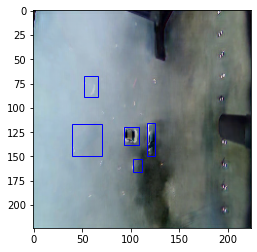

In [13]:
"""
Visualize various predictions
"""
with torch.no_grad():
    im, target, mask = dry_data.__getitem__(0)
    im = tfs.Normalize(mean=[0.64, 0.6, 0.58],std=[0.14,0.15, 0.152])(im)
    im = im.to(device)
    im = ffa_net(im.unsqueeze(0))[0]
    model.eval()
    result = model(im.unsqueeze(0))
    result = process_results(result)
    visualize_predicted_image_tensor(im.cpu(), result[0]['boxes'].cpu(), scale = None, normalized = False)
    